In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from prophet import Prophet

2025-02-24 04:49:04,363	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-02-24 04:49:04,635	INFO util.py:154 -- Outdated packages:
  ipywidgets==7.8.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
# Đọc dữ liệu với kiểu dữ liệu tối ưu
dtypes = {'Revenue': 'float32', 'Units': 'float32'}
train = pd.read_csv(r"D:\Du An\Data FLow\v1\data\train.csv", dtype=dtypes)
test = pd.read_csv(r"D:\Du An\Data FLow\v1\data\test.csv", dtype=dtypes)

# Giới hạn số lượng dòng nếu dữ liệu quá lớn
train = train.iloc[-100000:]  # Chỉ lấy 100k dòng gần nhất nếu cần

In [3]:
def ensure_stationarity(df, column, max_diff=2):
    df_adjusted = df.copy()
    series = df[column].dropna()
    diffs = 0
    p_value = adfuller(series.sample(n=min(len(series), 50000), random_state=42))[1]  # Kiểm định ADF trên tối đa 50k dòng
    
    print(f"\nChecking stationarity for {column}:")
    print(f"Initial p-value: {p_value:.4f}")
    
    while p_value > 0.05 and diffs < max_diff:
        series = series.diff().dropna()
        df_adjusted[column] = df_adjusted[column].diff()
        diffs += 1
        p_value = adfuller(series.sample(n=min(len(series), 50000), random_state=42))[1] if len(series) > 0 else 1.0
        print(f"After diff {diffs}: p-value = {p_value:.4f}")
    
    if diffs == max_diff and p_value > 0.05:
        print(f"Warning: {column} still non-stationary after {max_diff} differences")
    else:
        print(f"{column} is stationary after {diffs} differences")
    
    df_adjusted = df_adjusted.dropna().fillna(method='ffill')
    return df_adjusted

In [4]:
def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"{model_name} Results:")
    print(f"  R2: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    return y_pred

In [5]:
def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Thực tế', color='blue')
    plt.plot(y_pred, label=model_name, linestyle='--', color='orange')
    plt.title(f'Dự báo Doanh thu với {model_name}')
    plt.xlabel('Thời gian')
    plt.ylabel('Doanh thu')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


=== ARIMA Model ===

Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')



Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')


ARIMA Results:
  R2: -1.4448
  RMSE: 9099.0273


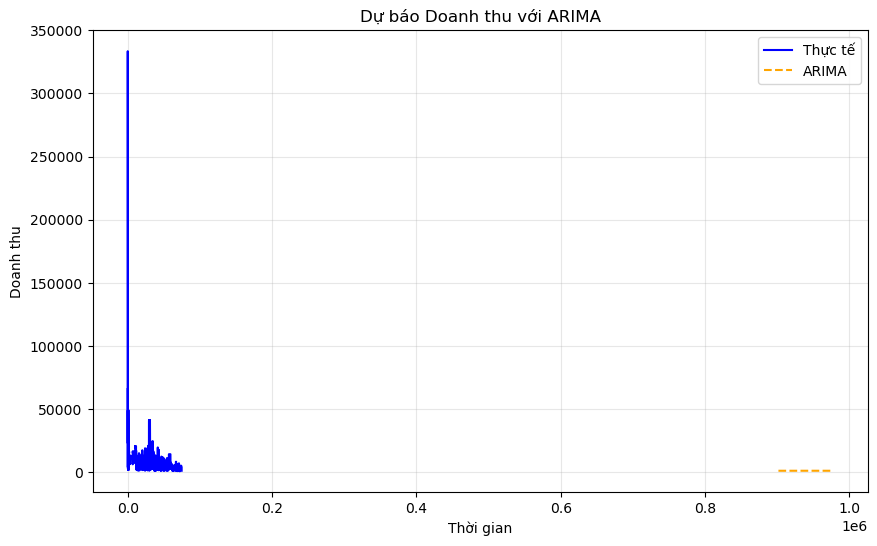

In [6]:
def run_arima():
    print("\n=== ARIMA Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')
    
    model = ARIMA(train_stationary['Revenue'].iloc[-50000:], order=(1, 1, 1)).fit()
    y_pred = model.forecast(steps=len(test_stationary))
    y_true = test_stationary['Revenue']
    
    y_pred = evaluate(y_true, y_pred, "ARIMA")
    plot_results(y_true, y_pred, "ARIMA")

run_arima()


=== LSTM Model ===

Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')



Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')
c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 24s 6ms/step - loss: 0.0031
Epoch 2/10
  17/3125 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 1.4351e-04

c:\Users\ADMIN\anaconda3\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


3125/3125 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - loss: 1.9086e-04
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 1.3707e-04
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 1.0219e-04
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 5.3372e-05
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - loss: 3.2911e-05
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 3.8801e-05
Epoch 8/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 22s 7ms/step - loss: 2.9526e-05
Epoch 9/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 4.0880e-05
Epoch 10/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2.5507e-05
LSTM Results:
  R2: -0.1339
  RMSE: 6007.5977


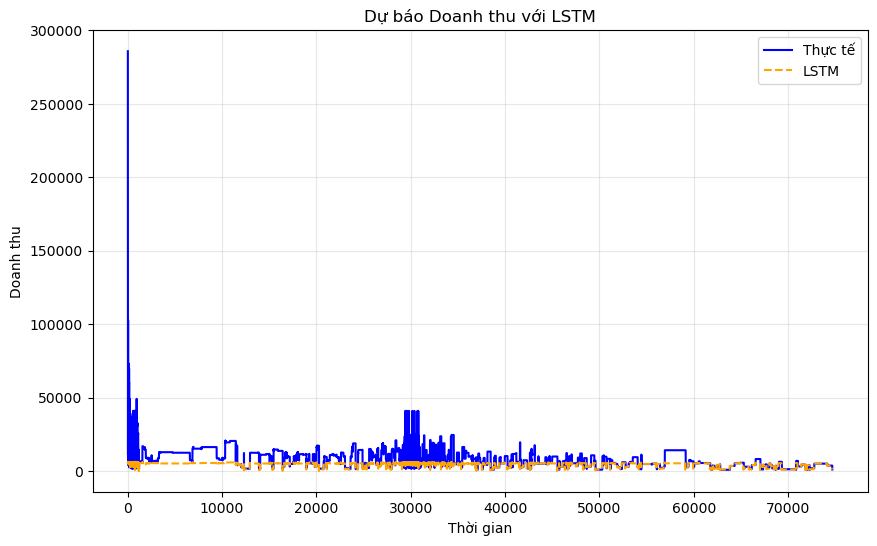

In [7]:
def run_lstm():
    print("\n=== LSTM Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_stationary[['Revenue']].iloc[-50000:])  # Giới hạn 50k dòng
    test_scaled = scaler.transform(test_stationary[['Revenue']])

    def create_sequences(data, seq_length=10):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)

    seq_length = 10
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)

    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=10, batch_size=16,  # Giảm batch size
              callbacks=[EarlyStopping(patience=3, restore_best_weights=True)], verbose=1)

    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]
    y_true = test_stationary['Revenue'][seq_length:]

    y_pred = evaluate(y_true, y_pred, "LSTM")
    plot_results(y_true, y_pred, "LSTM")

run_lstm()


=== XGBoost Model ===

Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')



Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences
XGBoost Results:
  R2: -0.7839
  RMSE: 7772.3604


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')


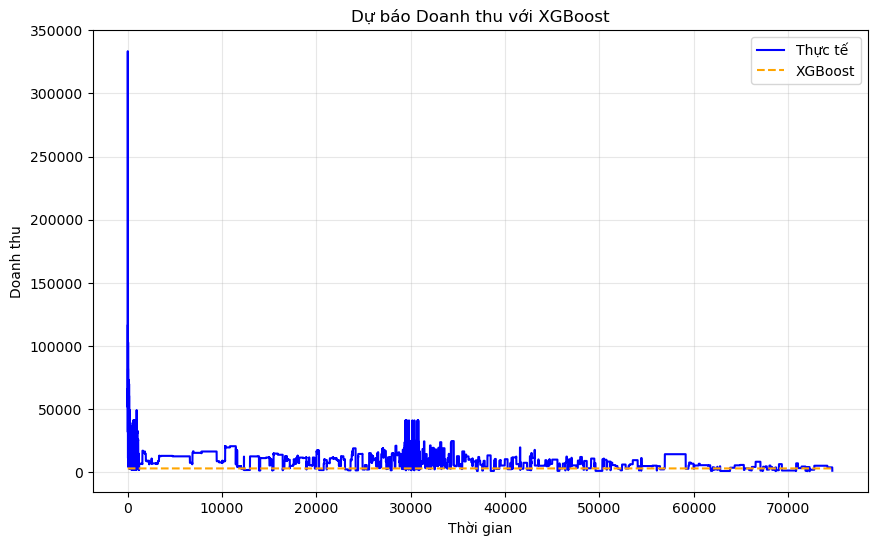

In [8]:
def run_xgboost():
    print("\n=== XGBoost Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')

    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    model.fit(train_stationary[['Units']].iloc[-50000:], train_stationary['Revenue'].iloc[-50000:])
    y_pred = model.predict(test_stationary[['Units']])
    y_true = test_stationary['Revenue']

    y_pred = evaluate(y_true, y_pred, "XGBoost")
    plot_results(y_true, y_pred, "XGBoost")

run_xgboost()

In [9]:
def run_patchtst():
    print("\n=== PatchTST Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')

    train_df = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(train_stationary), freq='D'), 'y': train_stationary['Revenue'], 'unique_id': '1'})
    test_df = pd.DataFrame({'ds': pd.date_range(start=train_df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=len(test_stationary), freq='D'), 'unique_id': '1'})

    nf = NeuralForecast(models=[PatchTST(input_size=10, h=1, max_steps=500)], freq='D')
    nf.fit(df=train_df.iloc[-50000:])
    y_pred = nf.predict(df=test_df)['PatchTST'].values
    y_true = test_stationary['Revenue']

    y_pred = evaluate(y_true, y_pred, "PatchTST")
    plot_results(y_true, y_pred, "PatchTST")

run_patchtst()


=== PatchTST Model ===

Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')



Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')


OutOfBoundsDatetime: Cannot generate range with start=1577836800000000000 and periods=100000

In [10]:
def run_prophet():
    print("\n=== Prophet Model ===")
    train_stationary = ensure_stationarity(train, 'Revenue')
    test_stationary = ensure_stationarity(test, 'Revenue')

    train_df = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(train_stationary), freq='D'), 'y': train_stationary['Revenue']})

    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train_df.iloc[-50000:])
    future = model.make_future_dataframe(periods=len(test_stationary), freq='D')
    forecast = model.predict(future)
    y_pred = forecast['yhat'][-len(test_stationary):].values
    y_true = test_stationary['Revenue']

    y_pred = evaluate(y_true, y_pred, "Prophet")
    plot_results(y_true, y_pred, "Prophet")

run_prophet()



=== Prophet Model ===

Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')



Checking stationarity for Revenue:
Initial p-value: 0.0000
Revenue is stationary after 0 differences


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_10832\3308307624.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_adjusted = df_adjusted.dropna().fillna(method='ffill')


OutOfBoundsDatetime: Cannot generate range with start=1577836800000000000 and periods=100000

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from xgboost import XGBRegressor
from prophet import Prophet
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST

def load_data(train_path, test_path):
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    return train, test

def ensure_stationarity(series, max_diff=2):
    diffs = 0
    p_value = adfuller(series.dropna())[1]
    while p_value > 0.05 and diffs < max_diff:
        series = series.diff().dropna()
        diffs += 1
        p_value = adfuller(series)[1] if len(series) > 0 else 1.0
    return series, diffs

def evaluate(y_true, y_pred, model_name):
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{model_name} Results:")
    print(f"  R2: {r2:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAPE: {mape:.4f}")

def plot_results(y_true, y_pred, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(y_true, label='Actual', color='blue')
    plt.plot(y_pred, label=model_name, linestyle='--', color='orange')
    plt.title(f'Forecast with {model_name}')
    plt.xlabel('Time')
    plt.ylabel('Revenue')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

def run_arima(train, test, column):
    train_series, _ = ensure_stationarity(train[column])
    model = ARIMA(train_series, order=(1, 1, 1)).fit()
    y_pred = model.forecast(steps=len(test))
    evaluate(test[column], y_pred, "ARIMA")
    plot_results(test[column], y_pred, "ARIMA")

def run_lstm(train, test, column):
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train[[column]])
    test_scaled = scaler.transform(test[[column]])
    
    def create_sequences(data, seq_length=10):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length])
            y.append(data[i + seq_length, 0])
        return np.array(X), np.array(y)
    
    seq_length = 10
    X_train, y_train = create_sequences(train_scaled, seq_length)
    X_test, y_test = create_sequences(test_scaled, seq_length)
    
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
        Dropout(0.2),
        LSTM(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=20, batch_size=32, callbacks=[EarlyStopping(patience=5, restore_best_weights=True)], verbose=1)
    
    y_pred_scaled = model.predict(X_test, verbose=0)
    y_pred = scaler.inverse_transform(y_pred_scaled)[:, 0]
    evaluate(test[column][seq_length:], y_pred, "LSTM")
    plot_results(test[column][seq_length:], y_pred, "LSTM")

def run_xgboost(train, test, target, feature):
    model = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    model.fit(train[[feature]], train[target])
    y_pred = model.predict(test[[feature]])
    evaluate(test[target], y_pred, "XGBoost")
    plot_results(test[target], y_pred, "XGBoost")

def run_patchtst(train, test, column):
    train_df = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(train), freq='D'), 'y': train[column], 'unique_id': '1'})
    test_df = pd.DataFrame({'ds': pd.date_range(start=train_df['ds'].iloc[-1] + pd.Timedelta(days=1), periods=len(test), freq='D'), 'unique_id': '1'})
    nf = NeuralForecast(models=[PatchTST(input_size=10, h=1, max_steps=500)], freq='D')
    nf.fit(df=train_df)
    y_pred = nf.predict(df=test_df)['PatchTST'].values
    evaluate(test[column], y_pred, "PatchTST")
    plot_results(test[column], y_pred, "PatchTST")

def run_prophet(train, test, column):
    train_df = pd.DataFrame({'ds': pd.date_range(start='2020-01-01', periods=len(train), freq='D'), 'y': train[column]})
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True)
    model.fit(train_df)
    future = model.make_future_dataframe(periods=len(test), freq='D')
    forecast = model.predict(future)
    y_pred = forecast['yhat'][-len(test):].values
    evaluate(test[column], y_pred, "Prophet")
    plot_results(test[column], y_pred, "Prophet")

if __name__ == "__main__":
    train, test = load_data(r"D:\Du An\Data FLow\v1\data\train.csv", r"D:\Du An\Data FLow\v1\data\test.csv")
    run_arima(train, test, 'Revenue')
    run_lstm(train, test, 'Revenue')
    run_xgboost(train, test, 'Revenue', 'Units')
    run_patchtst(train, test, 'Revenue')
    run_prophet(train, test, 'Revenue')


MemoryError: Unable to allocate 736. MiB for an array with shape (107, 901443) and data type float64